# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sub
import dash
from dash import dcc, html, Output, Input, State
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.trial import TrialState

from functools import partial
import random
import os
import itertools
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision.models import vgg16_bn, resnet50, resnet18, efficientnet_b0, densenet121, ResNet50_Weights, ResNet18_Weights, VGG16_BN_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks, draw_keypoints
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, ToPILImage
from torchvision.io import decode_image

from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from huggingface_hub import snapshot_download, hf_hub_download
import socket
import json
import sys
import io
import base64

# ROOT

## Save torchvision's fine grained visual classification aircraft dataset into your local drive 

## May take up to 10 minutes to download if you have not done so!

In [2]:

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, project_root)

from src.data_utils import FGVCAircraftDataset, get_datasets, get_loaders, get_raw
from src import aircraft_utils, models


In [3]:
ROOT = get_raw()

# Detect CUDA GPU if available

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# DataLoaders and DataSets instantiation

In [10]:
train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(img_size=224,batch_size=16,annot='variant')
train_dataset, val_dataset, test_dataset = get_datasets(224,16,'variant')

In [11]:
num_classes

100

# Model, Loss Func, Optimizer, Scheduler etc.

In [12]:

model=models.CAPResNet(num_classes, drop = 0.3563).to(device)
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
num_epochs = 20
criterion = nn.CrossEntropyLoss(label_smoothing = 0.046858)
optimizer = optim.Adam(model.parameters(), lr=5.1872e-05, weight_decay=0.002925) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = GradScaler(device)


# Load the model parameters if existed

In [13]:
# # Load the model
# model_file = os.path.join(os.pardir, "models", "best_model_variant.pth")
# model.load_state_dict(torch.load(model_file, weights_only=True))
# model.eval()


# Or start a whole training valuation loop

In [16]:
%%time
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
all_val_preds = []
all_val_labels = []
model_path = os.path.join(os.pardir, "models", "best_model.pth")

for epoch in range(num_epochs):

    train_loss, train_acc, t_loss_lst, t__acc_lst = aircraft_utils.train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, val_preds, val_labels, v_loss_lst, v_acc_lst = aircraft_utils.evaluate(model, val_loader, criterion, device)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    
    all_val_preds.extend(val_preds)
    all_val_labels.extend(val_labels)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # Step the scheduler
    #scheduler.step()# for all other schedulers
    scheduler.step(val_loss) # only for 'ReduceLROnPlateau'

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_path)  # Save best model
        print("✅ Model improved. Saving...")
    else:
        epochs_without_improvement += 1
        print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("⏹️ Early stopping triggered.")
        break


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5986, Train Acc: 0.0141
Val Loss: 4.5485, Val Acc: 0.0441
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.3738, Train Acc: 0.0591
Val Loss: 3.9850, Val Acc: 0.1296
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.8620, Train Acc: 0.1368
Val Loss: 3.4440, Val Acc: 0.2172
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.2966, Train Acc: 0.2208
Val Loss: 2.8362, Val Acc: 0.3180
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 2.8870, Train Acc: 0.3062
Val Loss: 2.5112, Val Acc: 0.3936
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.5995, Train Acc: 0.3653
Val Loss: 2.3002, Val Acc: 0.4332
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 2.3907, Train Acc: 0.4193
Val Loss: 2.1314, Val Acc: 0.4713
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 2.2064, Train Acc: 0.4646
Val Loss: 2.0153, Val Acc: 0.4932
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 2.0702, Train Acc: 0.5099
Val Loss: 1.8997, Val Acc: 0.5092
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 1.9455, Train Acc: 0.5408
Val Loss: 1.8436, Val Acc: 0.5506
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 1.8681, Train Acc: 0.5738
Val Loss: 1.7879, Val Acc: 0.5548
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 1.7821, Train Acc: 0.5945
Val Loss: 1.7393, Val Acc: 0.5782
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 1.7203, Train Acc: 0.6164
Val Loss: 1.6973, Val Acc: 0.5818
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 1.6515, Train Acc: 0.6296
Val Loss: 1.6685, Val Acc: 0.6043
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 1.5881, Train Acc: 0.6500
Val Loss: 1.6846, Val Acc: 0.5824
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 1.5441, Train Acc: 0.6707
Val Loss: 1.5958, Val Acc: 0.6181
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 1.4833, Train Acc: 0.6887
Val Loss: 1.6186, Val Acc: 0.6109
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 1.4769, Train Acc: 0.6935
Val Loss: 1.5738, Val Acc: 0.6193
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 1.4159, Train Acc: 0.7106
Val Loss: 1.5773, Val Acc: 0.6289
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 1.4068, Train Acc: 0.7091
Val Loss: 1.5744, Val Acc: 0.6262
⚠️ No improvement for 2 epoch(s).
CPU times: total: 36min 40s
Wall time: 36min 28s


Validation accuracy > Training accuracy:
This is not unusual early in training. It can happen due to:
Regularization effects (e.g., dropout active during training but not during validation).
Batch norm behavior differing between training and inference.
Small training batches causing noisy gradients.
Validation set being easier or more representative early on.

# Final Evaluation on generalizing unseen Test set, 
# Top-k accuracy and F1 scores 

In [17]:
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Evaluation", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_preds.append(outputs.cpu())
        final_labels.append(labels.cpu())

final_preds = torch.cat(final_preds)
final_labels = torch.cat(final_labels)

final_metrics = aircraft_utils.compute_metrics(final_labels, final_preds, k=3)
print("Final Evaluation Metrics:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")

Final Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Final Evaluation Metrics:
Top-1 Accuracy: 0.6271
Top-3 Accuracy: 0.8560
F1 Macro: 0.6222
F1 Micro: 0.6271


# Confusion Matrix

In [18]:
cm = confusion_matrix(all_val_labels, all_val_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracy = np.diag(cm_normalized)
tick_marks = np.arange(len(class_names))

# CM heatmap along with Lollipop scatter plot

In [19]:
# Create heatmap using Plotly
heatmap = go.Heatmap(
    z=cm_normalized,
    x=class_names,
    y=class_names,
    colorscale='Plasma',
    colorbar=dict(title='Accuracy'),
    hovertemplate='Actual: %{y}<br>Predicted: %{x}<br>Accuracy: %{z:.2%}<extra></extra>'
)

# Create scatter plot (lollipop style) for class accuracy
scatter = go.Scatter(
    x=class_names,
    y=class_accuracy,
    mode='markers+lines',
    marker=dict(size=8, color='blue'),
    line=dict(color='lightblue'),
    name='Class Accuracy',
    hovertemplate='Class: %{x}<br>Accuracy: %{y:.2%}<extra></extra>'
)

# Create subplots with corrected keyword 'shared_xaxes'
fig = sub.make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Normalized Confusion Matrix", "Accuracy per Class")
)

fig.add_trace(heatmap, row=1, col=1)
fig.add_trace(scatter, row=2, col=1)

fig.update_layout(
    height=1000,
    width=1200,
    title_text="Interactive Confusion Matrix with Accuracy",
    xaxis2=dict(tickangle=315),
    margin=dict(t=100)
)

fig.write_html(os.path.join(os.pardir, "outputs", "interactive_confusion_matrix.html"))
print("Interactive confusion matrix with variant level class accuracy saved as 'interactive_confusion_matrix.html'.")
fig.show()


Interactive confusion matrix with variant level class accuracy saved as 'interactive_confusion_matrix.html'.


# Best and Worst 5 classes model predicted

In [20]:
# Zip the class names and accuracies
zipped = list(zip(class_names, class_accuracy))

# Sort by accuracy
sorted_by_accuracy = sorted(zipped, key=lambda x: x[1], reverse=True)

# Get top 5 and bottom 5
top_5 = sorted_by_accuracy[:5]
bottom_5 = sorted_by_accuracy[-5:]
top_5, bottom_5

([('DH-82', 0.9212121212121213),
  ('Spitfire', 0.8909090909090909),
  ('DR-400', 0.8863636363636364),
  ('SR-20', 0.8560606060606061),
  ('C-130', 0.843939393939394)],
 [('A320', 0.14705882352941177),
  ('777-200', 0.14411764705882352),
  ('737-300', 0.12424242424242424),
  ('757-200', 0.09545454545454546),
  ('747-200', 0.04696969696969697)])

In [21]:
# Create a DataFrame
df = pd.DataFrame({'Class Name': class_names, 'Accuracy': class_accuracy})

# Sort by accuracy
df_sorted = df.sort_values(by='Accuracy', ascending=False)

df_sorted


,Class Name,Accuracy
57,DH-82,0.921212
95,Spitfire,0.890909
62,DR-400,0.886364
92,SR-20,0.856061
42,C-130,0.843939
...,...,...
25,A320,0.147059
19,777-200,0.144118
3,737-300,0.124242
14,757-200,0.095455


Visualization saved as 'class_accuracy_visualization.png'.


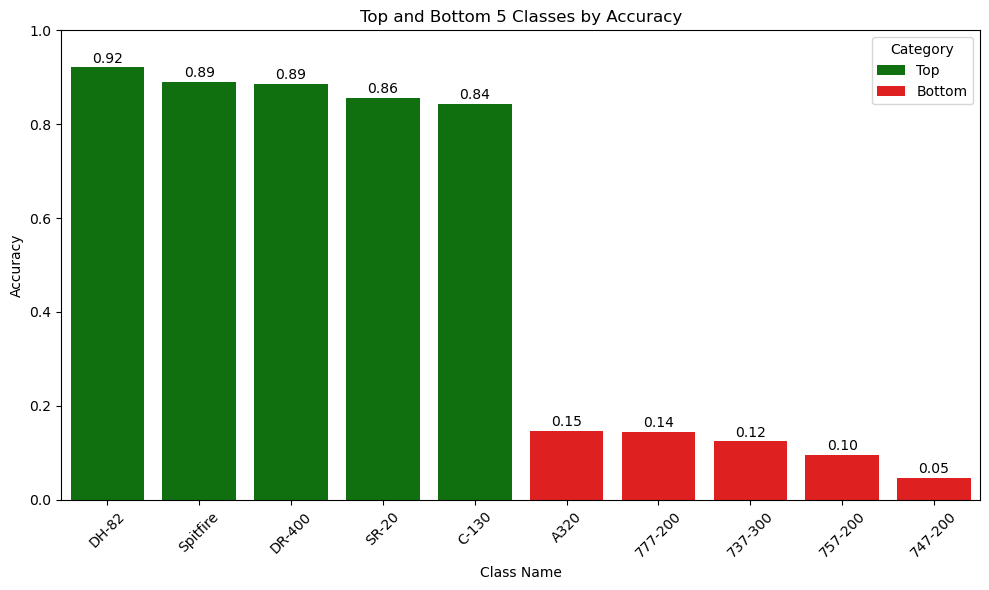

In [22]:
df_sorted = df_sorted.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Extract top 5 and bottom 5 classes
top5 = df_sorted.head(5).copy()
bottom5 = df_sorted.tail(5).copy()
top5['Category'] = 'Top'
bottom5['Category'] = 'Bottom'
df_vis = pd.concat([top5, bottom5], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_vis, x='Class Name', y='Accuracy', hue='Category', dodge=False, palette={'Top': 'green', 'Bottom': 'red'})
plt.title('Top and Bottom 5 Classes by Accuracy')
plt.ylim(0, 1)
for i, row in df_vis.iterrows():
    plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()


plt.savefig(os.path.join(os.pardir, "outputs", "class_accuracy_visualization.png"))
print("Visualization saved as 'class_accuracy_visualization.png'.")



Visualizations saved as 'accuracy_error_comparison.png'.


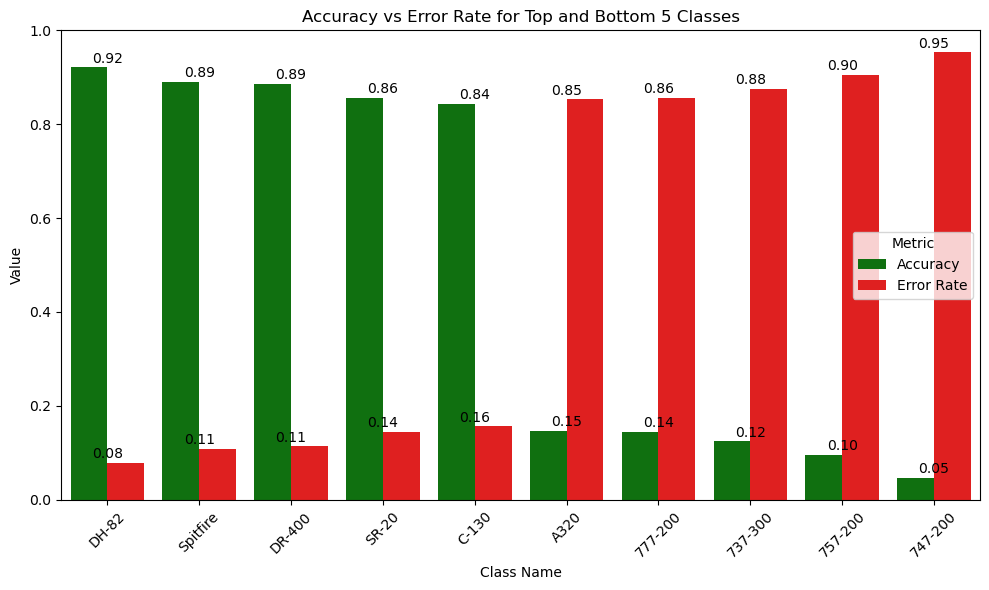

In [23]:
df_vis['Error Rate'] = 1 - df_vis['Accuracy']
df_melted = df_vis.melt(id_vars=['Class Name'], value_vars=['Accuracy', 'Error Rate'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Class Name', y='Value', hue='Metric', palette={'Accuracy': 'green', 'Error Rate': 'red'})
plt.title('Accuracy vs Error Rate for Top and Bottom 5 Classes')
plt.ylim(0, 1)
for i, row in df_melted.iterrows():
    plt.text(i % 10, row['Value'] + 0.01, f"{row['Value']:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(os.pardir, "outputs", "accuracy_error_comparison.png"))
#plt.close()

print("Visualizations saved as 'accuracy_error_comparison.png'.")




# Training and Validation Loss vs Accuracy across epochs

Visualization saved as 'train_val_loss_acc.png'.


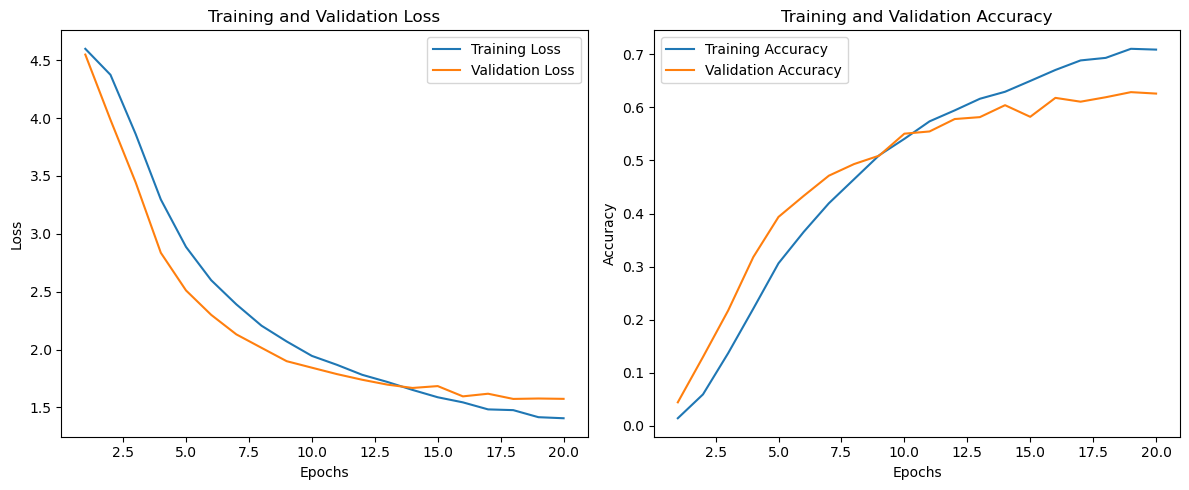

In [24]:

ep = range(1, len(train_loss_lst) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ep, train_loss_lst, label='Training Loss')
plt.plot(ep, val_loss_lst, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(ep, train_acc_lst, label='Training Accuracy')
plt.plot(ep, val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(os.pardir, "outputs", "train_val_loss_acc.png"))
print("Visualization saved as 'train_val_loss_acc.png'.")

NameError: name 'device' is not defined

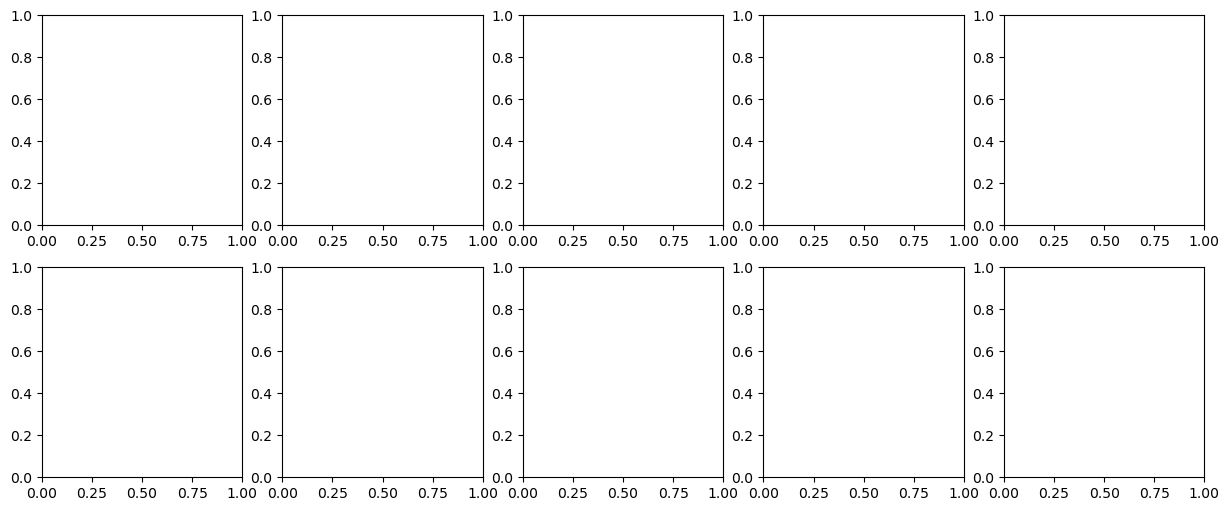

In [32]:
aircraft_utils.visualize_predictions(model, test_dataset, 10)